# Model

##  Model Formulation


### Sets and Indices

$i,j \in \text{Customers} \equiv L=\{0,1..(n-1)\}$: Set of locations where $0$ is the depot, and $n$ is the number of customers.

$k \in \text{Trucks} \equiv  V=\{0..K-1\}$: Index and set of trucks, where $K$ is the number of trucks.

### Parameters

$d_{i,j} \in \mathbb{R}^+$: Distance (total service time) from customer $i$ to customer $j$.

### Decision Variables

$x_{i,j,k} \in \{0,1 \}$: This binary variable is equal 1, if truck $k$ visits and goes directly from location $i$ to location $j$, and zero otherwise.

$y_{i,k} \in \{0,1 \}$: This binary variable is equal 1, if truck $k$ visits location $i$, and zero otherwise.

$z_{k} \in \{0,1 \}$: This binary variable is equal 1, if truck $k \in \{1,2..K\}$ is used, and zero otherwise.

### Objective Function

**Number of trucks**: Minimize number of trucks used.

\begin{equation}
\text{Minimize} \quad \sum_{k = 1}^{K} z_k
\end{equation}

### Constraints

**truck utilization**: For all locations different from the depot, i.e. $i > 0$, if the location is visited by truck $k$, then it is used.

\begin{equation}
y_{i,k} \leq z_{k} \quad \forall i \in L \setminus \{0\}, \; k \in V
\end{equation}


**Visit all customers**:  Each customer location is visited by exactly one truck.

\begin{equation}
\sum_{k \in V}  y_{i,k} = 1 \quad \forall i \in L \setminus \{0\}
\end{equation}

**Depot**: Depot is visited by every truck used. 

\begin{equation}
\sum_{k \in V}  y_{0,k} \geq \sum_{k \in V} z_k
\end{equation}

**Arriving at a location**: If location $j$ is visited by truck $k$, then the truck is coming from another location $i$.

\begin{equation}
\sum_{i \in L}  x_{i,j,k} =  y_{j,k}  \quad \forall j \in L, \; k \in V
\end{equation}

**Leaving a location**: If truck $k$ leaves location $j$, then the truck is going to another location $i$.

\begin{equation}
\sum_{i \in L}  x_{j,i,k} = y_{j,k}  \quad \forall j \in L, \; k \in V
\end{equation}

**Breaking symmetry**: **I GUESS** this is to minimize number of trucks used. we want to utilize previous trucks as much as possible before adding new ones

\begin{equation}
\sum_{i \in L}  y_{i,k} \geq \sum_{i \in L}  y_{i,k+1} \quad \forall k \in  \{0..K-1\}
\end{equation}

**Time windows**: Keep track of opening and closing times for each location.
$$O_i \leq s_i$$

$$s_i \leq C_i$$

**Timeline**: keep track of time to avoid subtours via big $M$ and either-or
$$s_i+d_{ij}-s_j \leq M(1-x_{ijk})$$

**max time contraint**: this is simplified at the moment, we are assuming each vehicle only takes 1 tour.
<!-- $$C_N = T_{max}$$ -->
$$C_0 = T_{max}$$

## Python Implementation

We import the Gurobi Python Module and other Python libraries.

In [138]:
import sys
import math
import random
from itertools import permutations
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# tested with Python 3.7.0 & Gurobi 9.1.0

## Input data  
We define all the input data for the model. The user defines the number of locations, including the depot, and the number of trucks. We randomly determine the coordinates of each location and then calculate the Euclidean distance between each pair of locations. We assume a speed of 60 km/hr, which is 1 km/min. Hence travel time is equal to the distance.

In [139]:
# number of locations, including the depot. The index of the depot is 0
n = 5
locations = [*range(n)]

# number of trucks
K = 3
trucks = [*range(K)]



# Create n random points
# Depot is located at (0,0) coordinates
random.seed(1)
points = [(0, 0)]
points += [(random.randint(0, 50), random.randint(0, 50)) for i in range(n-1)]

# Dictionary of Euclidean distance between each pair of points
# Assume a speed of 60 km/hr, which is 1 km/min. Hence travel time = distance
time = {(i, j):
        math.sqrt(sum((points[i][k]-points[j][k])**2 for k in range(2)))
        for i in locations for j in locations if i != j}

# big M
M = 1000 #TODO: to be changes

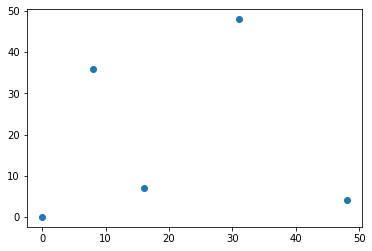

In [140]:
plt.scatter([x[0] for x in points], [x[1] for x in points])

## Model Deployment

We create a model and the variables. The decision variables determines the order in which each van visits a subset of custormers, which customer is visited by each van, and if a van is used or not.

In [141]:
m = gp.Model('lost_luggage_distribution.lp')

# Create variables: 

# x =1, if van  k  visits and goes directly from location  i  to location  j 
x = m.addVars(time.keys(), trucks, vtype=GRB.BINARY, name='FromToBy')

# y = 1, if customer i is visited by van k
y = m.addVars(locations, trucks, vtype=GRB.BINARY, name='visitBy')

# Number of trucks used is a decision variable
z = m.addVars(trucks, vtype=GRB.BINARY, name='used')

# Travel time per truck
t = m.addVars(trucks, name='travelTime') #TODO: add ub here for max TT

# Maximum travel time
T = m.addVar(name='maxTravelTime')

# Opening times o_i
o = m.addVars(locations, name='openingTime')

# Closing times
c = m.addVars(locations, name='closingTime')

# Service times s_i
serviceTime = m.addVars(locations, name='serviceTime')

## Constraints

For all locations different from depot, i.e. $i > 0$, if the location is visited by van $k$, then it is used.

In [142]:
# Truck utilization constraint
visitCustomer = m.addConstrs((y[i,k] <= z[k]  for k in trucks for i in locations if i > 0), name='visitCustomer' )

In [143]:
# Travel time constraint
# Exclude the time to return to the depot

travelTime = m.addConstrs((gp.quicksum(time[i,j]*x[i,j,k] for i,j in time.keys() if j > 0) == t[k] for k in trucks), name='travelTimeConstr')

maxTravelTime = m.addConstrs((t[k] <= T for k in trucks), name='maxTravelTimeConstr')

Each customer location is visited by exactly one van

In [144]:
# Visit all customers
visitAll = m.addConstrs((y.sum(i,'*') == 1 for i in locations if i > 0), name='visitAll' )

Depot is visited by every van used.

In [145]:
# Depot constraint
depotConstr = m.addConstr(y.sum(0,'*') >= z.sum(), name='depotConstr' )

If location  j  is visited by van  k , then the van is coming from another location  i.

In [146]:
# Arriving at a customer location constraint
ArriveConstr = m.addConstrs((x.sum('*',j,k) == y[j,k] for j,k in y.keys()), name='ArriveConstr' )

 If van  k  leaves location  j , then the van is going to another location  i.

In [147]:
# Leaving a customer location constraint
LeaveConstr = m.addConstrs((x.sum(j,'*',k) == y[j,k] for j,k in y.keys()), name='LeaveConstr' )

Breaking symmetry constraints.

In [148]:
breakSymm = m.addConstrs((y.sum('*',k-1) >= y.sum('*',k) for k in trucks if k>0), name='breakSymm' )

NEW: Adding time windows

In [149]:
# openingConstr = m.addConstrs((o[i]<=serviceTime[i] for i in locations)
#     , name='openingConstr')

# closingConstr = m.addConstrs((c[i]>=serviceTime[i] for i in locations)
#     , name='closingConstr')   

NEW: timeline

In [150]:
#d[i,j] is our final goal
# timelineConstr = m.addConstrs((serviceTime[i] + time[i,j] - serviceTime[j] <= M*(1-x[i,j,k]) for i,j,k in x.keys())
#     , name='timelineConstr'
# )

NEW: max time

In [151]:
# maxTimeConstr = m.addConstr(c[0] == T
#     , name='maxTimeConstr'
# )

### Objective Function
We use two hierarchical objectives:
- First, minimize the number of trucks used
- Then, minimize the maximum of the time limit constraints

In [152]:
m.ModelSense = GRB.MINIMIZE
m.setObjectiveN(z.sum(), 0, priority=1, name="Number of trucks")
m.setObjectiveN(T, 1, priority=0, name="Travel time")

### Callback Definition
Subtour constraints prevent a van from visiting a set of destinations without starting or ending at the Heathrow depot. Because there are an exponential number of these constraints, we don't want to add them all to the model. Instead, we use a callback function to find violated subtour constraints and add them to the model as lazy constraints.

In [153]:
# Callback - use lazy constraints to eliminate sub-tours
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._x)
        selected = gp.tuplelist((i,j) for i, j, k in model._x.keys()
                                if vals[i, j, k] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < n: 
            for k in trucks:
                model.cbLazy(gp.quicksum(model._x[i, j, k]
                                         for i, j in permutations(tour, 2))
                             <= len(tour)-1)


# Given a tuplelist of edges, find the shortest subtour not containing depot (0)
def subtour(edges):
    unvisited = list(range(1, n))
    cycle = range(n+1)  # initial length has 1 more city
    while unvisited:
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            if current != 0:
                unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j == 0 or j in unvisited]
        if 0 not in thiscycle and len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

## Solve the model

In [154]:
# Verify model formulation

m.write('lost_luggage_distribution.lp')

# Run optimization engine
m._x = x
m.Params.LazyConstraints = 1
m.optimize(subtourelim)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 55 rows, 97 columns and 269 nonzeros
Model fingerprint: 0xfd3b97cd
Variable types: 19 continuous, 78 integer (78 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 41 rows and 63 columns
Presolve time: 0.01s
Presolved: 14 rows and 34 columns
---------------------------------------------------------------------------

Multi-objec

## Analysis

The optimal route of each van used and the total lost luggage delivery time report follows.

In [155]:
# Print optimal routes
for k in trucks:
    route = gp.tuplelist((i,j) for i,j in time.keys() if x[i,j,k].X > 0.5)
    if route:
        i = 0
        print(f"Route for van {k}: {i}", end='')
        while True:
            i = route.select(i, '*')[0][1]
            print(f" -> {i}", end='')
            if i == 0:
                break
        print(f". Travel time: {round(t[k].X,2)} min")

print(f"Max travel time: {round(T.X,2)}")

Route for van 0: 0 -> 3 -> 2 -> 0. Travel time: 49.6 min
Route for van 1: 0 -> 1 -> 0. Travel time: 36.88 min
Route for van 2: 0 -> 4 -> 0. Travel time: 57.14 min
Max travel time: 57.14


## References

H. Paul Williams, Model Building in Mathematical Programming, fifth edition.

Copyright © 2020 Gurobi Optimization, LLC